# Exploring flux data and environmental covariables

tern data: https://portal.tern.org.au/#/d0436eef

## Load modules

In [ ]:
# !pip install dea-tools==0.2.4
# !pip install odc-algo==0.2.2
# !pip install mlforecast
# !pip install dask_ml==1.9.0

In [12]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump
from pprint import pprint
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from preprocess_input_data import preprocess_data

## Analysis Parameters

In [2]:
base='https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/'

# suffix = 'Whroo/2021_v1/L6/default/Whroo_L6_20111201_20210724_Monthly.nc'
# suffix = 'Otway/2021_v1/L6/default/Otway_L6_20070811_20110101_Monthly.nc'
# suffix = 'WallabyCreek/2022_v1/L6/default/WallabyCreek_L6_20050825_20130409_Monthly.nc'
# suffix = 'WombatStateForest/2022_v1/L6/default/WombatStateForest_L6_20100120_20210529_Monthly.nc'
# suffix='Tumbarumba/2021_v1/L6/default/Tumbarumba_L6_20020107_20191231_Monthly.nc'
# suffix = 'CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc'


# Gingin/2021_v1/L6/default/Gingin_L6_20111013_20201231_Monthly.nc
# AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc
# TiTreeEast/2022_v1/L6/default/TiTreeEast_L6_20120718_20220117_Monthly.nc
# DryRiver/2022_v1/L6/default/DryRiver_L6_20091025_20220218_Monthly.nc
# Litchfield/2021_v1/L6/default/Litchfield_L6_20150623_20210725_Monthly.nc
# CalperumChowilla/2022_v1/L6/default/Calperum_L6_20100730_20220216_Monthly.nc

#tropical forests
# suffix = 'RobsonCreek/2022_v1/L6/default/RobsonCreek_L6_20130801_20211218_Monthly.nc'
# suffix = 'CapeTribulation/2022_v1/L6/default/CapeTribulation_L6_20100101_20181102_Monthly.nc'

## Prepare Data

In [3]:
aa = preprocess_data(base, 'Tumbarumba/2021_v1/L6/default/Tumbarumba_L6_20020107_20191231_Monthly.nc')
bb = preprocess_data(base, 'AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc')
cc = preprocess_data(base, 'CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc')
dd = preprocess_data(base, 'CalperumChowilla/2022_v1/L6/default/Calperum_L6_20100730_20220216_Monthly.nc')
ee = preprocess_data(base, 'Whroo/2021_v1/L6/default/Whroo_L6_20111201_20210724_Monthly.nc')
ff = preprocess_data(base, 'Gingin/2021_v1/L6/default/Gingin_L6_20111013_20201231_Monthly.nc')
gg = preprocess_data(base, 'WombatStateForest/2022_v1/L6/default/WombatStateForest_L6_20100120_20210529_Monthly.nc')
hh = preprocess_data(base, 'DryRiver/2022_v1/L6/default/DryRiver_L6_20091025_20220218_Monthly.nc')
ii = preprocess_data(base, 'Litchfield/2021_v1/L6/default/Litchfield_L6_20150623_20210725_Monthly.nc')
jj = preprocess_data(base, 'TiTreeEast/2022_v1/L6/default/TiTreeEast_L6_20120718_20220117_Monthly.nc')

#One left out for testing  
# olo = preprocess_data(base, 'TiTreeEast/2022_v1/L6/default/TiTreeEast_L6_20120718_20220117_Monthly.nc')

Dropping bands ['nbart_red', 'nbart_nir', 'nbart_blue']
Dropping bands ['nbart_red', 'nbart_nir', 'nbart_blue']
Dropping bands ['nbart_red', 'nbart_nir', 'nbart_blue']
Dropping bands ['nbart_red', 'nbart_nir', 'nbart_blue']
Dropping bands ['nbart_red', 'nbart_nir', 'nbart_blue']
Dropping bands ['nbart_red', 'nbart_nir', 'nbart_blue']
Dropping bands ['nbart_red', 'nbart_nir', 'nbart_blue']


/home/547/cb3058/.digitalearthau/dea-env/20200713/local/lib/python3.6/site-packages/dea_tools/datahandling.py:567: UserWarning: Multiple UTM zones ['epsg:32653', 'epsg:32652'] were returned for this query. Defaulting to the most common zone: epsg:32653
  UserWarning)


Dropping bands ['nbart_red', 'nbart_nir', 'nbart_blue']
Dropping bands ['nbart_red', 'nbart_nir', 'nbart_blue']
Dropping bands ['nbart_red', 'nbart_nir', 'nbart_blue']


## Modelling

In [4]:
sites=[aa,bb,cc,dd,ee,ff,gg,hh,ii,jj]

In [5]:
xx = []
yy = []
for site in sites:
    df_var=site.drop('NEE_LT', axis=1) 
    df_nee=site['NEE_LT']
    x = df_var.reset_index(drop=True).to_numpy()
    y = df_nee.reset_index(drop=True).to_numpy()
    xx.append(x)
    yy.append(y)

x = np.concatenate([x for x in xx])
y = np.concatenate([y for y in yy])

print(x.shape)

(1183, 12)


## Test model robustness with nested K-fold cross validation

In [6]:
inner_cv_splits = 5

outer_cv_splits = 5

test_size = 0.20

In [7]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': ["mse", "mae", "poisson"],
    'max_features': ['auto', 'log2', None],
    'n_estimators': [200,300,400]
}

In [8]:
outer_cv = KFold(n_splits=outer_cv_splits, shuffle=True,
                        random_state=0)

# lists to store results of CV testing
acc = []
rmse=[]
i = 1
for train_index, test_index in outer_cv.split(x, y):
    print(f"Working on {i}/5 outer cv split", end='\r')
    model = RandomForestRegressor(random_state=1, n_jobs=7)

    # index training, testing, and coordinate data
    X_tr, X_tt = x[train_index, :], x[test_index, :]
    y_tr, y_tt = y[train_index], y[test_index]
    
    # inner split on data within outer split
    inner_cv = KFold(n_splits=inner_cv_splits,
                     shuffle=True,
                     random_state=0)
    
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        n_jobs=7,
        refit=True,
        cv=inner_cv.split(X_tr, y_tr),
    )

    clf.fit(X_tr, y_tr)
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # ROC AUC
    # Overall accuracy
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    # F1 scores
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    i += 1

In [9]:
print("Mean MAE accuracy: "+ str(round(np.mean(acc), 2)))
print("Std dev of MAE accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean RMSE: "+ str(round(np.mean(rmse), 2)))
print("Std dev RMSE: "+ str(round(np.std(rmse), 2)))

Mean MAE accuracy: 14.63
Std dev of MAE accuracy: 0.55


Mean RMSE: 20.95
Std dev RMSE: 0.76


## Optimize model

In [15]:
#generate n_splits of train-test_split
rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=0)

#instatiate a gridsearchCV
clf = GridSearchCV(RandomForestRegressor(),
                   param_grid,
                   scoring='neg_mean_absolute_error',
                   verbose=1,
                   cv=rs.split(x, y),
                   n_jobs=7)

clf.fit(x, y)

In [16]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The MAE score using these parameters is: ")
print(round(clf.best_score_, 2))

The most accurate combination of tested parameters is: 
{'criterion': 'mse', 'max_features': 'auto', 'n_estimators': 200}


The MAE score using these parameters is: 
-14.85


## Fit on all data using best params

In [17]:
model = RandomForestRegressor(**clf.best_params_, random_state=1, n_jobs=7)
model.fit(x, y)

RandomForestRegressor(n_estimators=200, n_jobs=7, random_state=1)

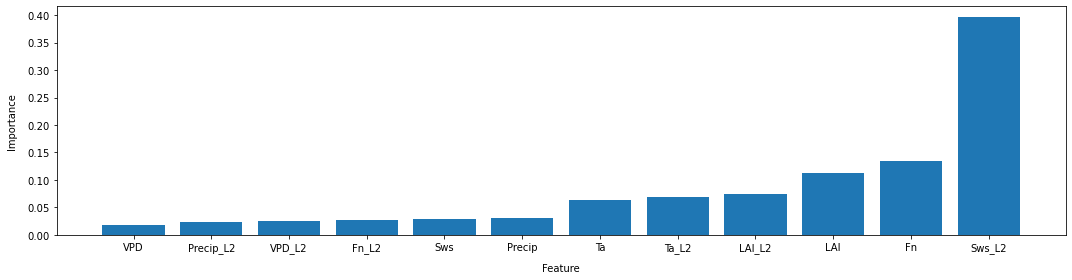

In [18]:
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(15,4))
plt.bar(x=np.array(df_var.columns.values)[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Feature', labelpad=10)
plt.tight_layout()

## Save the model

In [21]:
dump(model, '/g/data/os22/chad_tmp/NEE_modelling/results/ml_model.joblib')

['/g/data/os22/chad_tmp/NEE_modelling/results/ml_model.joblib']

## Predict

In [22]:
y_pred = model.predict(x)

rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("RMSE:", rmse);

RMSE: 7.738


### Compare at site 1

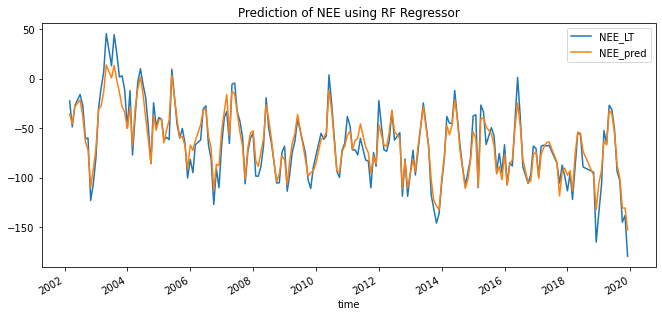

In [23]:
compare = pd.DataFrame(data=y_pred[0:len(aa)], index=aa.index).rename({0:'NEE_pred'}, axis=1)
aa.join(compare).plot(y=['NEE_LT', 'NEE_pred'], figsize=(11,5))
plt.title('Prediction of NEE using RF Regressor');

### Compare at site 2

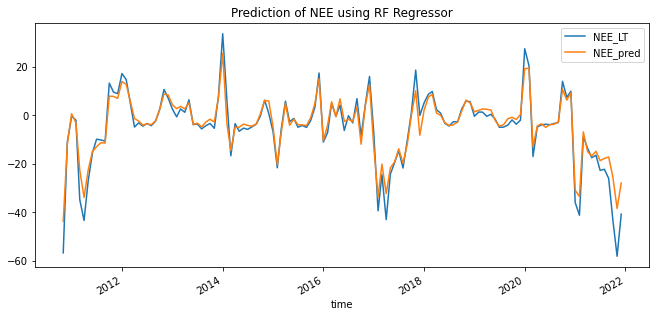

In [24]:
compare = pd.DataFrame(data=y_pred[len(aa):len(aa)+len(bb)], index=bb.index).rename({0:'NEE_pred'}, axis=1)
bb.join(compare).plot(y=['NEE_LT', 'NEE_pred'], figsize=(11,5))
plt.title('Prediction of NEE using RF Regressor');

---

## Predict, then compare on site not included in training data

In [ ]:
x=olo.drop('NEE_LT', axis=1) # predictors
y=olo['NEE_LT'] # target

In [ ]:
y_pred = model.predict(x)

In [ ]:
compare = pd.DataFrame(data=y_pred, index=olo.index).rename({0:'NEE_pred'}, axis=1)
olo.join(compare).plot(y=['NEE_LT', 'NEE_pred'], figsize=(11,5))
plt.title('Prediction of NEE using RF Regressor trained on other sites');

rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("RMSE:", rmse);

In [ ]:
# import mlforecast as mlf
# from mlforecast.core import TimeSeries
# from mlforecast.forecast import Forecast
# from mlforecast.distributed.models.xgb import XGBForecast
# import dask.dataframe as dd
# from mlforecast.distributed.forecast import DistributedForecast
# from window_ops.expanding import expanding_mean
# from window_ops.rolling import rolling_mean

# from statsmodels.tsa.vector_ar.var_model import VAR
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tools.eval_measures import rmse
# from statsmodels.tsa.stattools import grangercausalitytests